# **Sneaker Retail Price Analysis & Insights**

The purpose of this project is to build a sneaker price analysis system that collects, compares, and analyzes prices from retail platforms such as Nike and Zappos. The focus is on understanding pricing trends, platform-specific price differences, and market patterns for popular sneaker models. By tracking these trends, we aim to measure how factors like brand, model, and release timing influence retail pricing.

The solution will provide actionable insights for retailers, analysts, and enthusiasts who want to understand pricing behavior, identify trends, and make informed decisions about purchasing or monitoring sneakers. Currently, most price checks are manual or rely on third-party reports that are limited or costly. Our system automates this process by scraping reliable data, storing it in a structured format, and making it easy to analyze over time.

The approach is inspired by other industries where price tracking is essential, such as e-commerce competitor monitoring, but is specialized for sneakers. While a human could manually collect this data, our pipeline scales the process and allows for deeper analytical insights.

For now, we assume product names can be normalized across the two platforms, displayed prices reflect actual retail prices, and the U.S. market will serve as our baseline for comparison.

## **Data Collection**

In this section, we will collect sneaker data from retail platforms only, specifically Nike and Zappos.

For these retail sites, we will use requests + BeautifulSoup or other HTML parsing methods, as most of the relevant content is available directly in the page source and does not require handling dynamic JavaScript.

Across both platforms, we will extract consistent fields that are available on each site:

Brand

Product Name / Model

Colorway (when shown)

Release Date (when available)

Retail Price

Product URL

Image URL

Platform (source of the data)

At the end of this section, we will combine the results from Nike and Zappos into a single dataset for analysis, which will allow us to compare prices, identify trends, and explore platform-specific differences in retail pricing.

In [1]:
# Import Libraries
!pip install beautifulsoup4

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Target Sneakers

TARGET_SNEAKERS = [
    "Air Jordan 1 Retro High",
    "Nike Dunk Low",
    "Air Force 1",
    "Air Max 90",
    "Blazer Mid",
    "Air Max 97",
    "Air Jordan 4 Retro",
    "Nike SB Dunk",
    "Air Max 270",
    "Nike React Element 87"
]

**NIKE SCRAPING**

In this section, we scrape Nike’s website to collect detailed product information for our target sneaker models. The process includes normalizing raw product titles to standardized model names, extracting pricing, URLs, and images, and consolidating the data into a structured format. This ensures consistency across the dataset and allows us to track availability, retail prices, and product details accurately. The resulting CSV provides a clean foundation for later analysis, including price comparisons and market trend insights.

In [3]:
# Sneakers Model Normalization

def normalize_model(raw_model):
    if not raw_model:
        return None

    model_lower = raw_model.lower()
    if "air jordan 1" in model_lower and "retro" in model_lower:
        return "Air Jordan 1 Retro High"
    elif "dunk low" in model_lower:
        return "Nike Dunk Low"
    elif "air force 1" in model_lower:
        return "Air Force 1"
    elif "air max 90" in model_lower:
        return "Air Max 90"
    elif "blazer mid" in model_lower:
        return "Blazer Mid"
    elif "air max 97" in model_lower:
        return "Air Max 97"
    elif "air jordan 4" in model_lower:
        return "Air Jordan 4 Retro"
    elif "sb dunk" in model_lower:
        return "Nike SB Dunk"
    elif "air max 270" in model_lower:
        return "Air Max 270"
    elif "react element 87" in model_lower:
        return "Nike React Element 87"

    return None


In [4]:
# Nike Scraper Function

def scrape_nike(query, max_results=5):
    """
    Scrapes Nike website for sneaker data.
    Returns a list of product dictionaries.
    """

    # Search URL
    url = f"https://www.nike.com/w?q={query.replace(' ', '%20')}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                      "AppleWebKit/537.36 (KHTML, like Gecko) "
                      "Chrome/120.0.0.0 Safari/537.36"
    }

    try:
        response = requests.get(url, headers=headers, timeout=15)
        response.raise_for_status()
    except Exception as e:
        print(f"Error fetching {query}: {e}")
        return []

    soup = BeautifulSoup(response.text, "html.parser")
    products = []

    product_elements = soup.select("figure[data-testid='product-card'], div.product-card")
    if not product_elements:
        print(f"No products found for {query}")
        return []

    for i, item in enumerate(product_elements[:max_results]):
        try:
            # Model
            model_el = item.select_one("h3.product-card__title, div.product-card__title")
            raw_model = model_el.get_text(strip=True) if model_el else None
            normalized_model = normalize_model(raw_model)
            if not normalized_model:
                continue

            # Price
            price_el = item.select_one("div.product-price")
            price = price_el.get_text(strip=True) if price_el else None
            if price:
                price = re.sub(r"[^\d.$]", "", price)

            # Product URL
            link_el = item.select_one("a")
            product_url = link_el.get("href") if link_el else None
            if product_url and not product_url.startswith("http"):
                product_url = "https://www.nike.com" + product_url

            # Image URL
            img_el = item.select_one("img[src]")
            img_url = img_el.get("src") if img_el else None
            if img_url and img_url.startswith("//"):
                img_url = "https:" + img_url

            products.append({
                "brand": "Nike",
                "model": normalized_model,
                "title": f"{normalized_model}",
                "colorway": raw_model.replace(normalized_model, '').strip() if raw_model else None,
                "release_date": None,
                "retail_price": price,
                "resale_price": None,
                "product_url": product_url,
                "image_url": img_url,
                "platform": "Nike",
                "search_query": query
            })
        except Exception as e:
            print(f"Error parsing product {i+1}: {e}")
            continue

    return products

In [5]:
# Run Scraper

nike_data = []
for sneaker in TARGET_SNEAKERS:
    print(f"Searching Nike for: {sneaker}")
    results = scrape_nike(sneaker)
    nike_data.extend(results)
    print(f"Found {len(results)} products for {sneaker}")

Searching Nike for: Air Jordan 1 Retro High
Found 2 products for Air Jordan 1 Retro High
Searching Nike for: Nike Dunk Low
Found 5 products for Nike Dunk Low
Searching Nike for: Air Force 1
Found 4 products for Air Force 1
Searching Nike for: Air Max 90
Found 5 products for Air Max 90
Searching Nike for: Blazer Mid
Found 3 products for Blazer Mid
Searching Nike for: Air Max 97
Found 3 products for Air Max 97
Searching Nike for: Air Jordan 4 Retro
Found 3 products for Air Jordan 4 Retro
Searching Nike for: Nike SB Dunk
Found 5 products for Nike SB Dunk
Searching Nike for: Air Max 270
Found 5 products for Air Max 270
Searching Nike for: Nike React Element 87
Found 0 products for Nike React Element 87


This run confirms that our Nike scraper is working as intended. For each sneaker model in the target list, we can see how many matching products were found. This step helps validate both the scraper logic and product availability on the Nike platform. Notice that some models (like the Blazer Mid and React Element 87) returned no results, which is also useful information - it highlights gaps in availability or possible changes in Nike’s catalog. These counts give us a first look at the product landscape before moving into price analysis and cross-platform comparisons.

In [6]:
# Save as CSV

nike_df = pd.DataFrame(nike_data)
nike_df.to_csv("nike_products.csv", index=False)
print("Saved Nike products to 'nike_products.csv'")

Saved Nike products to 'nike_products.csv'


In [7]:
# View first 5 rows
nike_df.head()

,brand,model,title,colorway,release_date,retail_price,resale_price,product_url,image_url,platform,search_query
0,Nike,Air Jordan 1 Retro High,Air Jordan 1 Retro High,"OG ""Shattered Backboard""",None,$185,None,https://www.nike.com/t/air-jordan-1-retro-high...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Air Jordan 1 Retro High
1,Nike,Air Jordan 1 Retro High,Air Jordan 1 Retro High,"OG ""Baroque Brown and Sail""",None,$185,None,https://www.nike.com/t/air-jordan-1-retro-high...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Air Jordan 1 Retro High
2,Nike,Nike Dunk Low,Nike Dunk Low,Retro,None,$120,None,https://www.nike.com/t/dunk-low-retro-mens-sho...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Nike Dunk Low
3,Nike,Nike Dunk Low,Nike Dunk Low,,None,$92,None,https://www.nike.com/t/dunk-low-big-kids-shoes...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Nike Dunk Low
4,Nike,Nike Dunk Low,Nike Dunk Low,,None,$120,None,https://www.nike.com/t/dunk-low-womens-shoes-k...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Nike Dunk Low


**ZAPPOS SCRAPER**

In this section, we collect sneaker listings from Zappos for the target models. The scraper extracts key details such as brand, model, colorway, price, and URLs while normalizing raw product titles to standardized model names. Colorway extraction further cleans the dataset for accurate comparison. This ensures that all Zappos listings are aligned with our Nike data, allowing consistent cross-platform analysis of pricing, availability, and market trends. The results are saved as a CSV for downstream analysis and resale insights.

In [8]:
# Allowed brands
ALLOWED_BRANDS = {"Nike"}

In [9]:
# Model Normalization

def normalize_model_zappos(raw_model, search_query):
    """
    Normalize raw Zappos product title to a clean model name.
    """
    if not raw_model:
        return None

    raw_lower = raw_model.lower()
    query_lower = search_query.lower()

    # Mapping search terms to normalized model names
    target_models = {
        "air jordan 1": "Air Jordan 1 Retro High",
        "dunk low": "Nike Dunk Low",
        "air force 1": "Air Force 1",
        "air max 90": "Air Max 90",
        "blazer mid": "Blazer Mid",
        "air max 97": "Air Max 97",
        "air jordan 4": "Air Jordan 4 Retro",
        "sb dunk": "Nike SB Dunk",
        "air max 270": "Air Max 270",
        "react element 87": "Nike React Element 87"
    }

    for key, model_name in target_models.items():
        if key in raw_lower or key in query_lower:
            return model_name

    return None

In [10]:
# Extract Colorway

def extract_colorway(raw_model, normalized_model):
    """
    Extract colorway from the raw product title.
    """
    if not raw_model or not normalized_model:
        return None

    # Remove the normalized model name from the raw title
    clean_text = raw_model.replace(normalized_model, '', 1)

    # List of common descriptors to remove from title to isolate colorway
    descriptors = [
        r'shoes', r'cleats', r'boots', r'indoor', r'soccer', r'running',
        r'sneakers', r'\(\w+\s*kid[^)]*\)', r'\s+\w+\s*kid'
    ]
    for desc in descriptors:
        clean_text = re.sub(desc, '', clean_text, flags=re.IGNORECASE).strip()

    # Remove extra spaces and non-alphanumeric characters
    clean_text = re.sub(r'[\s\W_]+', ' ', clean_text).strip()

    # Capitalize each word in the final colorway string
    return ' '.join(word.capitalize() for word in clean_text.split()) if clean_text else None

In [11]:
# Zappos Scraper Function

def search_zappos(query, max_results=5):
    """
    Scrape Zappos for sneaker listings based on a search query.
    """
    print(f"Searching Zappos for: {query}")
    search_url = f"https://www.zappos.com/search?term={query.replace(' ', '%20')}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                      "AppleWebKit/537.36 (KHTML, like Gecko) "
                      "Chrome/120.0.0.0 Safari/537.36",
        "Accept-Language": "en-US,en;q=0.9"
    }

    try:
        res = requests.get(search_url, headers=headers, timeout=15)
        res.raise_for_status()
        soup = BeautifulSoup(res.text, "html.parser")  # Parse HTML response
    except Exception as e:
        print(f"Error fetching {query}: {e}")
        return []

    product_elements = soup.select("article")
    if not product_elements:
        print(f"No products found for {query}")
        return []

    products = []
    for i, item in enumerate(product_elements[:max_results]):
        try:
            # Extract brand and filter for allowed brands
            brand_el = item.select_one("dd[class*='lB-z'] span")
            brand = brand_el.get_text(strip=True) if brand_el else None
            if brand not in ALLOWED_BRANDS:
                continue

            # Extract price and clean it
            price_el = item.select_one("dd span[class*='u1-z']")
            price = price_el.get_text(strip=True) if price_el else None
            if price:
                price = re.sub(r"[^\d.$]", "", price)

            # Get product URL
            link_el = item.select_one("a[class*='iB-z']")
            product_url = link_el.get("href") if link_el and link_el.has_attr("href") else None
            if product_url and not product_url.startswith("http"):
                product_url = "https://www.zappos.com" + product_url

            # Get image URL
            img_el = item.select_one("figure img[src]")
            img_url = img_el.get("src") if img_el else None
            if img_url and img_url.startswith("//"):
                img_url = "https:" + img_url

            # Extract and normalize model name
            name_el = item.select_one("dd[class*='mB-z']")
            raw_model = name_el.get_text(strip=True) if name_el else None
            normalized_model = normalize_model_zappos(raw_model, query)
            if not normalized_model:
                continue

            # Extract colorway and build title
            colorway = extract_colorway(raw_model, normalized_model)
            title = f"{brand} - {normalized_model}" if brand else normalized_model

            # Append cleaned product data
            products.append({
                "brand": brand,
                "model": normalized_model,
                "title": title,
                "colorway": colorway,
                "release_date": None,
                "retail_price": price,
                "resale_price": None,
                "product_url": product_url,
                "image_url": img_url,
                "platform": "Zappos",
                "search_query": query
            })
            print(f"{i+1}. {title} - {price}")
        except Exception as e:
            print(f"Error parsing product {i+1}: {e}")
            continue

    return products




In [12]:
# Run Scraper

zappos_data = []
for sneaker in TARGET_SNEAKERS:
    results = search_zappos(sneaker, max_results=5)
    zappos_data.extend(results)
    print(f"Found {len(results)} products for {sneaker}")
    time.sleep(2)

Searching Zappos for: Air Jordan 1 Retro High
Found 0 products for Air Jordan 1 Retro High
Searching Zappos for: Nike Dunk Low
No products found for Nike Dunk Low
Found 0 products for Nike Dunk Low
Searching Zappos for: Air Force 1
1. Nike - Air Force 1 - $40.00
Found 1 products for Air Force 1
Searching Zappos for: Air Max 90
1. Nike - Air Max 90 - $95.00
2. Nike - Air Max 90 - $145.00
3. Nike - Air Max 90 - $95.00
5. Nike - Air Max 90 - $90.00
Found 4 products for Air Max 90
Searching Zappos for: Blazer Mid
Found 0 products for Blazer Mid
Searching Zappos for: Air Max 97
No products found for Air Max 97
Found 0 products for Air Max 97
Searching Zappos for: Air Jordan 4 Retro
Found 0 products for Air Jordan 4 Retro
Searching Zappos for: Nike SB Dunk
No products found for Nike SB Dunk
Found 0 products for Nike SB Dunk
Searching Zappos for: Air Max 270
1. Nike - Air Max 270 - $85.00
2. Nike - Air Max 270 - $85.00
Found 2 products for Air Max 270
Searching Zappos for: Nike React Element 

This section shows the results of scraping Zappos for our target sneaker models. The scraper successfully extracted available products, including prices, titles, and colorways, while skipping models that were unavailable. These results highlight which models are currently listed on Zappos and provide a first look at potential price variations compared to retail, setting the stage for cross-platform analysis and resale insights.

In [13]:
# Save result to csv
zappos_df = pd.DataFrame(zappos_data)
zappos_df.to_csv("zappos_products.csv", index=False)
print("Saved Zappos products to 'zappos_products.csv'")


Saved Zappos products to 'zappos_products.csv'


In [14]:
# Preview first 5 rows
zappos_df.head()

,brand,model,title,colorway,release_date,retail_price,resale_price,product_url,image_url,platform,search_query
0,Nike,Air Force 1,Nike - Air Force 1,Offcourt Slide,None,$40.00,None,https://www.zappos.com/p/nike-offcourt-slide-a...,https://m.media-amazon.com/images/I/61jvoyb1s8...,Zappos,Air Force 1
1,Nike,Air Max 90,Nike - Air Max 90,Air Max Excee,None,$95.00,None,https://www.zappos.com/p/nike-air-max-excee-su...,https://m.media-amazon.com/images/I/71Mr8TiSf5...,Zappos,Air Max 90
2,Nike,Air Max 90,Nike - Air Max 90,Pegasus 41,None,$145.00,None,https://www.zappos.com/p/nike-pegasus-41-phant...,https://m.media-amazon.com/images/I/715tDZ0bL2...,Zappos,Air Max 90
3,Nike,Air Max 90,Nike - Air Max 90,Air Max Excee,None,$95.00,None,https://www.zappos.com/p/nike-air-max-excee-sa...,https://m.media-amazon.com/images/I/613X5pJvzI...,Zappos,Air Max 90
4,Nike,Air Max 90,Nike - Air Max 90,Air Max Sc,None,$90.00,None,https://www.zappos.com/p/nike-air-max-sc-black...,https://m.media-amazon.com/images/I/71rMV8l1Ek...,Zappos,Air Max 90


## **Data Cleaning And Preparation**

In this section, we standardize and clean the collected sneaker data to ensure consistency across platforms. This includes normalizing model names, handling missing values, formatting prices, and removing duplicates. Clean and structured data allows for accurate comparisons, trend analysis, and meaningful insights into pricing patterns and market availability.

In [15]:
# Check for missing values
print("\nMissing values in Nike data:")
print(nike_df.isnull().sum())


Missing values in Nike data:
brand            0
model            0
title            0
colorway         0
release_date    35
retail_price     0
resale_price    35
product_url      0
image_url        0
platform         0
search_query     0
dtype: int64


In [16]:
print("\nMissing values in Zappos data:")
print(zappos_df.isnull().sum())


Missing values in Zappos data:
brand           0
model           0
title           0
colorway        0
release_date    8
retail_price    0
resale_price    8
product_url     0
image_url       0
platform        0
search_query    0
dtype: int64


In [17]:
# Standard column names
cols = [
    "brand", "model", "title", "colorway", "release_date",
    "retail_price", "resale_price", "product_url",
    "image_url", "platform", "search_query"
]

In [18]:
# Ensure data has standardize column names
nike_df = nike_df[cols]
zappos_df = zappos_df[cols]

In [19]:
# Clean price column for both data
def clean_price(price_str):
    if pd.isna(price_str):
        return None
    price_str = str(price_str).replace("$", "").replace(",", "").strip()
    try:
        return float(price_str)
    except:
        return None

In [20]:
# Apply the clean price function
nike_df["retail_price"] = nike_df["retail_price"].apply(clean_price)
zappos_df["retail_price"] = zappos_df["retail_price"].apply(clean_price)

In [21]:
# Preview retail price column
print(nike_df["retail_price"].head(5))
print(zappos_df["retail_price"].head(5))

0    185.0
1    185.0
2    120.0
3     92.0
4    120.0
Name: retail_price, dtype: float64
0     40.0
1     95.0
2    145.0
3     95.0
4     90.0
Name: retail_price, dtype: float64


In [22]:
# Fill missing or empty colorways with Unknown
nike_df["colorway"] = nike_df["colorway"].fillna("Unknown")
nike_df["colorway"] = nike_df["colorway"].replace("", "Unknown")

zappos_df["colorway"] = zappos_df["colorway"].replace("", "Unknown")
zappos_df["colorway"] = zappos_df["colorway"].fillna("Unknown")

In [23]:
# Fill missing release dates with 'Unknown' for now
nike_df["release_date"] = nike_df["release_date"].fillna("Unknown")
zappos_df["release_date"] = zappos_df["release_date"].fillna("Unknown")

In [24]:
# Preview data
print("\nNike data")
display(nike_df.head())
print("\nZappos data")
display(zappos_df.head())


Nike data


,brand,model,title,colorway,release_date,retail_price,resale_price,product_url,image_url,platform,search_query
0,Nike,Air Jordan 1 Retro High,Air Jordan 1 Retro High,"OG ""Shattered Backboard""",Unknown,185.0,None,https://www.nike.com/t/air-jordan-1-retro-high...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Air Jordan 1 Retro High
1,Nike,Air Jordan 1 Retro High,Air Jordan 1 Retro High,"OG ""Baroque Brown and Sail""",Unknown,185.0,None,https://www.nike.com/t/air-jordan-1-retro-high...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Air Jordan 1 Retro High
2,Nike,Nike Dunk Low,Nike Dunk Low,Retro,Unknown,120.0,None,https://www.nike.com/t/dunk-low-retro-mens-sho...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Nike Dunk Low
3,Nike,Nike Dunk Low,Nike Dunk Low,Unknown,Unknown,92.0,None,https://www.nike.com/t/dunk-low-big-kids-shoes...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Nike Dunk Low
4,Nike,Nike Dunk Low,Nike Dunk Low,Unknown,Unknown,120.0,None,https://www.nike.com/t/dunk-low-womens-shoes-k...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Nike Dunk Low



Zappos data


,brand,model,title,colorway,release_date,retail_price,resale_price,product_url,image_url,platform,search_query
0,Nike,Air Force 1,Nike - Air Force 1,Offcourt Slide,Unknown,40.0,None,https://www.zappos.com/p/nike-offcourt-slide-a...,https://m.media-amazon.com/images/I/61jvoyb1s8...,Zappos,Air Force 1
1,Nike,Air Max 90,Nike - Air Max 90,Air Max Excee,Unknown,95.0,None,https://www.zappos.com/p/nike-air-max-excee-su...,https://m.media-amazon.com/images/I/71Mr8TiSf5...,Zappos,Air Max 90
2,Nike,Air Max 90,Nike - Air Max 90,Pegasus 41,Unknown,145.0,None,https://www.zappos.com/p/nike-pegasus-41-phant...,https://m.media-amazon.com/images/I/715tDZ0bL2...,Zappos,Air Max 90
3,Nike,Air Max 90,Nike - Air Max 90,Air Max Excee,Unknown,95.0,None,https://www.zappos.com/p/nike-air-max-excee-sa...,https://m.media-amazon.com/images/I/613X5pJvzI...,Zappos,Air Max 90
4,Nike,Air Max 90,Nike - Air Max 90,Air Max Sc,Unknown,90.0,None,https://www.zappos.com/p/nike-air-max-sc-black...,https://m.media-amazon.com/images/I/71rMV8l1Ek...,Zappos,Air Max 90


In [25]:
# Remove duplicates
nike_df = nike_df.drop_duplicates(subset=["brand", "model", "colorway", "platform"])
zappos_df = zappos_df.drop_duplicates(subset=["brand", "model", "colorway", "platform"])

In [26]:
# Check shape of data
print("Shapes of data")
print("Nike data shape:")
print(nike_df.shape)
print("\nZappos data shape:")
print(zappos_df.shape)

Shapes of data
Nike data shape:
(19, 11)

Zappos data shape:
(6, 11)


In [27]:
# Merge datasets
combined_df = pd.concat([nike_df, zappos_df], ignore_index=True)
combined_df = combined_df.reset_index(drop=True)

In [28]:
# Preview the combined data
print("Combined dataset preview:")
display(combined_df.head())
print("\nCombined dataset info:")
display(combined_df.info())

Combined dataset preview:


,brand,model,title,colorway,release_date,retail_price,resale_price,product_url,image_url,platform,search_query
0,Nike,Air Jordan 1 Retro High,Air Jordan 1 Retro High,"OG ""Shattered Backboard""",Unknown,185.0,None,https://www.nike.com/t/air-jordan-1-retro-high...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Air Jordan 1 Retro High
1,Nike,Air Jordan 1 Retro High,Air Jordan 1 Retro High,"OG ""Baroque Brown and Sail""",Unknown,185.0,None,https://www.nike.com/t/air-jordan-1-retro-high...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Air Jordan 1 Retro High
2,Nike,Nike Dunk Low,Nike Dunk Low,Retro,Unknown,120.0,None,https://www.nike.com/t/dunk-low-retro-mens-sho...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Nike Dunk Low
3,Nike,Nike Dunk Low,Nike Dunk Low,Unknown,Unknown,92.0,None,https://www.nike.com/t/dunk-low-big-kids-shoes...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Nike Dunk Low
4,Nike,Nike Dunk Low,Nike Dunk Low,SE,Unknown,102.0,None,https://www.nike.com/t/dunk-low-se-big-kids-bo...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Nike Dunk Low



Combined dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         25 non-null     object 
 1   model         25 non-null     object 
 2   title         25 non-null     object 
 3   colorway      25 non-null     object 
 4   release_date  25 non-null     object 
 5   retail_price  25 non-null     float64
 6   resale_price  0 non-null      object 
 7   product_url   25 non-null     object 
 8   image_url     25 non-null     object 
 9   platform      25 non-null     object 
 10  search_query  25 non-null     object 
dtypes: float64(1), object(10)
memory usage: 2.3+ KB


None

In [29]:
# Unique values for Nike data columns
print("NIKE DATA")
for col in nike_df.columns:
    print(f"\nColumn: {col}")
    print(nike_df[col].unique())

NIKE DATA

Column: brand
['Nike']

Column: model
['Air Jordan 1 Retro High' 'Nike Dunk Low' 'Air Force 1' 'Air Max 90'
 'Blazer Mid' 'Air Max 97' 'Air Jordan 4 Retro' 'Air Max 270']

Column: title
['Air Jordan 1 Retro High' 'Nike Dunk Low' 'Air Force 1' 'Air Max 90'
 'Blazer Mid' 'Air Max 97' 'Air Jordan 4 Retro' 'Air Max 270']

Column: colorway
['OG "Shattered Backboard"' 'OG "Baroque Brown and Sail"' 'Retro'
 'Unknown' 'SE' "Nike  '07" "Nike  '07 EasyOn" 'Nike  LE' 'Nike  Premium'
 'Nike' 'Nike  EasyOn' 'Nike  LTR' "Nike  '77" 'Nike SB Zoom'
 'Nike  By You' 'Nike  By Fans, For Fans' '"Cave Stone and Black"']

Column: release_date
['Unknown']

Column: retail_price
[185.   120.    92.   102.   115.    90.   145.   135.    82.    73.97
  95.   200.   220.   160.   170.  ]

Column: resale_price
[None]

Column: product_url
['https://www.nike.com/t/air-jordan-1-retro-high-og-shattered-backboard-mens-shoes-Xqtsfw/DZ5485-008'
 'https://www.nike.com/t/air-jordan-1-retro-high-og-baroque-brown-

In [30]:
# Unique values for Zappos dataset
print("ZAPPOS DATA")
for col in zappos_df.columns:
    print(f"\nColumn: {col}")
    print(zappos_df[col].unique())

ZAPPOS DATA

Column: brand
['Nike']

Column: model
['Air Force 1' 'Air Max 90' 'Air Max 270' 'Nike React Element 87']

Column: title
['Nike - Air Force 1' 'Nike - Air Max 90' 'Nike - Air Max 270'
 'Nike - Nike React Element 87']

Column: colorway
['Offcourt Slide' 'Air Max Excee' 'Pegasus 41' 'Air Max Sc'
 'Air Max Nuaxis' 'Pegasus 41 Gore Tex']

Column: release_date
['Unknown']

Column: retail_price
[ 40.  95. 145.  90.  85. 160.]

Column: resale_price
[None]

Column: product_url
['https://www.zappos.com/p/nike-offcourt-slide-anthracite-black-black/product/10020782/color/252407'
 'https://www.zappos.com/p/nike-air-max-excee-summit-white-summit-white-light-british-tan/product/10020701/color/1115771'
 'https://www.zappos.com/p/nike-pegasus-41-phantom-black-picante-red-atmosphere/product/10020722/color/1119511'
 'https://www.zappos.com/p/nike-air-max-sc-black-white-black/product/9487110/color/11196'
 'https://www.zappos.com/p/nike-air-max-nuaxis-white-black-white/product/10020698/color/2

**NORMALIZATION**

In this step, we standardize brand names, model names, titles, colorways, release dates, and prices across the dataset. This ensures consistency, corrects variations in spelling or formatting, and fills missing values, making the data ready for accurate analysis and comparison across platforms.

In [31]:
# Define normalization function
def normalize_combined_data(df):
    df = df.copy()

    # Normalize brand
    df["brand"] = df["brand"].str.strip().str.title()
    df["brand"] = df["brand"].replace({
        "Nike, Inc.": "Nike",
        "Nike USA": "Nike"
    })

    # Normalize model names
    model_map = {
        "Air Force One": "Air Force 1",
        "Airforce 1": "Air Force 1",
        "AJ1 Retro High": "Air Jordan 1 Retro High",
        "Jordan 1 Retro High": "Air Jordan 1 Retro High",
        "Airmax 90": "Air Max 90",
        "Airmax 97": "Air Max 97",
        "React Element 87": "Nike React Element 87"
    }
    df["model"] = df["model"].replace(model_map)

    # Strip unusual spacing / capitalization
    df["model"] = df["model"].str.strip()

    # Normalize titles
    df["title"] = df["title"].str.replace("Nike - ", "", regex=False)
    df["title"] = df["title"].str.strip()

    # Replace missing entries with "Unknown"
    df["colorway"] = df["colorway"].replace({"": "Unknown", None: "Unknown"})
    df["colorway"] = df["colorway"].fillna("Unknown")

    # Normalize release date
    df["release_date"] = df["release_date"].replace({"": "Unknown", None: "Unknown"})
    df["release_date"] = df["release_date"].fillna("Unknown")

    # Normalize retail price
    df["retail_price"] = df["retail_price"].astype(float)

    # If resale price column is empty, keep it as Nan
    df["resale_price"] = df["resale_price"].replace({"":None})

    return df

In [32]:
# Apply normalization function
normalized_df = normalize_combined_data(combined_df)
display(normalized_df.head())

,brand,model,title,colorway,release_date,retail_price,resale_price,product_url,image_url,platform,search_query
0,Nike,Air Jordan 1 Retro High,Air Jordan 1 Retro High,"OG ""Shattered Backboard""",Unknown,185.0,None,https://www.nike.com/t/air-jordan-1-retro-high...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Air Jordan 1 Retro High
1,Nike,Air Jordan 1 Retro High,Air Jordan 1 Retro High,"OG ""Baroque Brown and Sail""",Unknown,185.0,None,https://www.nike.com/t/air-jordan-1-retro-high...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Air Jordan 1 Retro High
2,Nike,Nike Dunk Low,Nike Dunk Low,Retro,Unknown,120.0,None,https://www.nike.com/t/dunk-low-retro-mens-sho...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Nike Dunk Low
3,Nike,Nike Dunk Low,Nike Dunk Low,Unknown,Unknown,92.0,None,https://www.nike.com/t/dunk-low-big-kids-shoes...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Nike Dunk Low
4,Nike,Nike Dunk Low,Nike Dunk Low,SE,Unknown,102.0,None,https://www.nike.com/t/dunk-low-se-big-kids-bo...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Nike Dunk Low


In [33]:
# Shape of normalized data
print("\nShape of data:", normalized_df.shape)


Shape of data: (25, 11)


In [34]:
# Check unique values in colorway column
normalized_df["colorway"].unique()

array(['OG "Shattered Backboard"', 'OG "Baroque Brown and Sail"', 'Retro',
       'Unknown', 'SE', "Nike  '07", "Nike  '07 EasyOn", 'Nike  LE',
       'Nike  Premium', 'Nike', 'Nike  EasyOn', 'Nike  LTR', "Nike  '77",
       'Nike SB Zoom', 'Nike  By You', 'Nike  By Fans, For Fans',
       '"Cave Stone and Black"', 'Offcourt Slide', 'Air Max Excee',
       'Pegasus 41', 'Air Max Sc', 'Air Max Nuaxis',
       'Pegasus 41 Gore Tex'], dtype=object)

In [35]:
# Function to clean colorway column and create edition column
def clean_colorway_and_edition(colorway):
    if pd.isna(colorway) or colorway.strip() == "":
        return "Unknown", "Standard"

    text = str(colorway).strip()

    # Explicit mappings for messy colorways
    known_colorways = {
        'OG "Shattered Backboard"': ("Shattered Backboard", "OG"),
        'OG "Baroque Brown and Sail"': ("Baroque Brown and Sail", "OG"),
        '"Cave Stone and Black"': ("Cave Stone and Black", "Standard"),
        'Cave Stone and Black': ("Cave Stone and Black", "Standard")
    }
    if text in known_colorways:
        return known_colorways[text]

    # Detect special editions based on keywords
    if "SE" in text or "Special Edition" in text:
        return "Unknown", "Special Edition"
    if "LE" in text or "Limited" in text:
        return "Unknown", "Limited Edition"
    if "Premium" in text:
        return "Unknown", "Premium"
    if "By You" in text:
        return "Unknown", "Custom"
    if "OG" in text:
        # # Extract color for OG editions
        clean_color = text.replace('OG "', '').replace('"', '').replace("OG ", "")
        return clean_color, "OG"

    # # If text contains common color words, mark as standard edition
    color_words = ["black", "white", "blue", "red", "brown", "stone", "sail", "gray", "green"]
    if any(word in text.lower() for word in color_words):
        return text, "Standard"

    return "Unknown", "Standard"

In [36]:
# Apply the colorway function to clean the colorway column
normalized_df[["colorway", "edition_type"]] = normalized_df["colorway"].apply(
    lambda x: pd.Series(clean_colorway_and_edition(x))
)

In [37]:
# Display few rows of the data
display(normalized_df.head())

,brand,model,title,colorway,release_date,retail_price,resale_price,product_url,image_url,platform,search_query,edition_type
0,Nike,Air Jordan 1 Retro High,Air Jordan 1 Retro High,Shattered Backboard,Unknown,185.0,None,https://www.nike.com/t/air-jordan-1-retro-high...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Air Jordan 1 Retro High,OG
1,Nike,Air Jordan 1 Retro High,Air Jordan 1 Retro High,Baroque Brown and Sail,Unknown,185.0,None,https://www.nike.com/t/air-jordan-1-retro-high...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Air Jordan 1 Retro High,OG
2,Nike,Nike Dunk Low,Nike Dunk Low,Unknown,Unknown,120.0,None,https://www.nike.com/t/dunk-low-retro-mens-sho...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Nike Dunk Low,Standard
3,Nike,Nike Dunk Low,Nike Dunk Low,Unknown,Unknown,92.0,None,https://www.nike.com/t/dunk-low-big-kids-shoes...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Nike Dunk Low,Standard
4,Nike,Nike Dunk Low,Nike Dunk Low,Unknown,Unknown,102.0,None,https://www.nike.com/t/dunk-low-se-big-kids-bo...,"https://static.nike.com/a/images/c_limit,w_592...",Nike,Nike Dunk Low,Special Edition


**EXPLORATORY DATA ANALYSIS**

In this section, we examine the cleaned sneaker dataset to understand patterns, trends, and distributions. This includes analyzing model availability, pricing ranges, edition types, and platform-specific differences. EDA helps uncover insights, identify anomalies, and guides further analysis for pricing comparisons and market strategy.

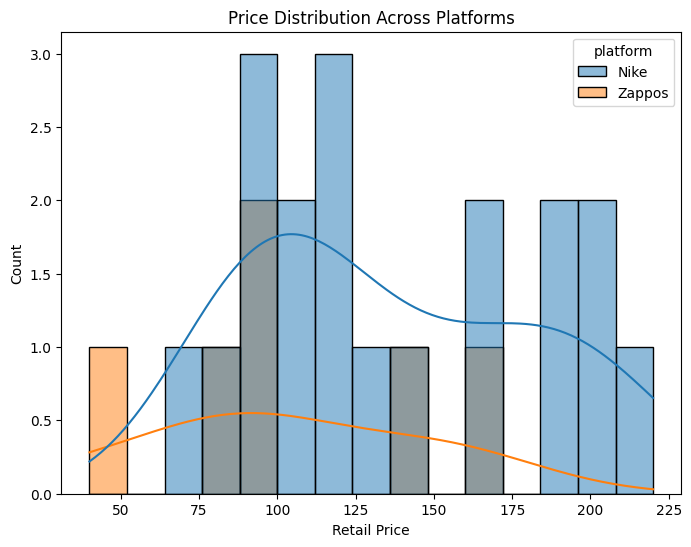

In [38]:
# Histogram of Prices
plt.figure(figsize=(8,6))
sns.histplot(data=normalized_df, x="retail_price", hue="platform", bins=15, kde=True)
plt.title("Price Distribution Across Platforms")
plt.xlabel("Retail Price")
plt.savefig("price_distribution_across_platforms.png")
plt.show()

This chart shows where Nike and Zappos set their prices. Nike's prices are clustered tightly on the right, meaning they mostly sell expensive sneakers at a premium. Zappos, however, has a much wider spread, covering budget options all the way up to high-end models. This tells us that Zappos caters to a broader range of customers, while Nike focuses on the premium segment of the market.

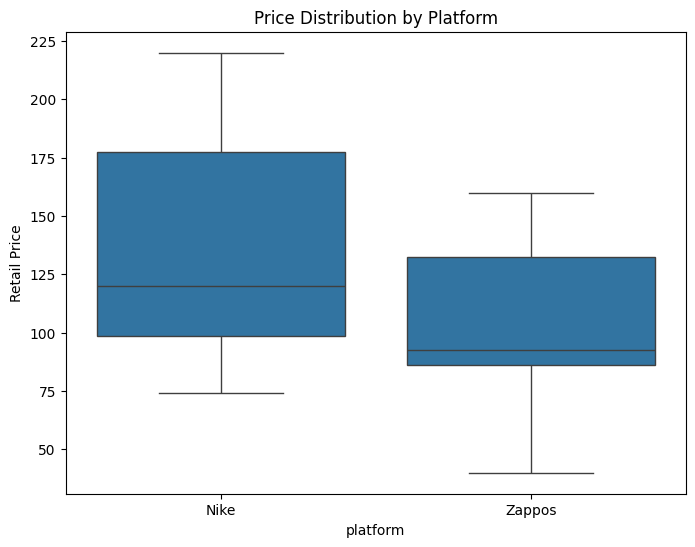

In [39]:
# Price Distribution by Platform
plt.figure(figsize=(8,6))
sns.boxplot(data=normalized_df,
            x="platform",
            y="retail_price")
plt.title("Price Distribution by Platform")
plt.ylabel("Retail Price")
plt.savefig("price_distribution_by_platform.png")
plt.show()

This box plot makes the pricing difference between the two platforms crystal clear. Nike's box is tall and positioned high, confirming they consistently charge premium prices with little discounting. Zappos has a much shorter box and a lower overall range, showing they generally offer cheaper prices and have a much tighter, more budget-focused selection. For a buyer, this means Zappos is generally the place for better deals, while Nike is where you go for the latest high-end releases.

In [40]:
# Group average retail price by brand and platform
avg_brand = (
    normalized_df.groupby(["platform", "brand"])["retail_price"]
    .mean()
    .reset_index()
    .sort_values(by="retail_price", ascending=False)
    .reset_index(drop=True)
)
display(avg_brand.head())

,platform,brand,retail_price
0,Nike,Nike,136.156316
1,Zappos,Nike,102.500000


From the data, we can see that Nike products on the Nike platform have a higher average retail price 138.63 compared to Nike products listed on Zappos $102.50. This highlights a noticeable price difference across platforms, which can inform resale strategy and market comparison.

In [41]:
# Group average retail price by model and platform
avg_model = (
    normalized_df.groupby(["platform", "model"])["retail_price"]
    .mean()
    .reset_index()
    .sort_values(by="retail_price", ascending=False)
    .reset_index(drop=True)
)
display(avg_model)

,platform,model,retail_price
0,Nike,Air Max 97,200.000000
1,Nike,Air Jordan 4 Retro,190.000000
2,Nike,Air Jordan 1 Retro High,185.000000
3,Nike,Air Max 270,170.000000
4,Zappos,Nike React Element 87,160.000000
5,Nike,Air Max 90,116.000000
6,Zappos,Air Max 90,110.000000
7,Nike,Air Force 1,106.666667
8,Nike,Nike Dunk Low,104.666667
9,Zappos,Air Max 270,85.000000


The table highlights the average retail price for each sneaker model across platforms. Nike’s Air Max 97, Air Jordan 4 Retro, and Air Jordan 1 Retro High are the most expensive on the Nike platform, while some models like Air Force 1 and Air Max 270 are significantly cheaper on Zappos. This emphasizes how pricing varies by platform and model, providing insight for market analysis and potential resale opportunities.

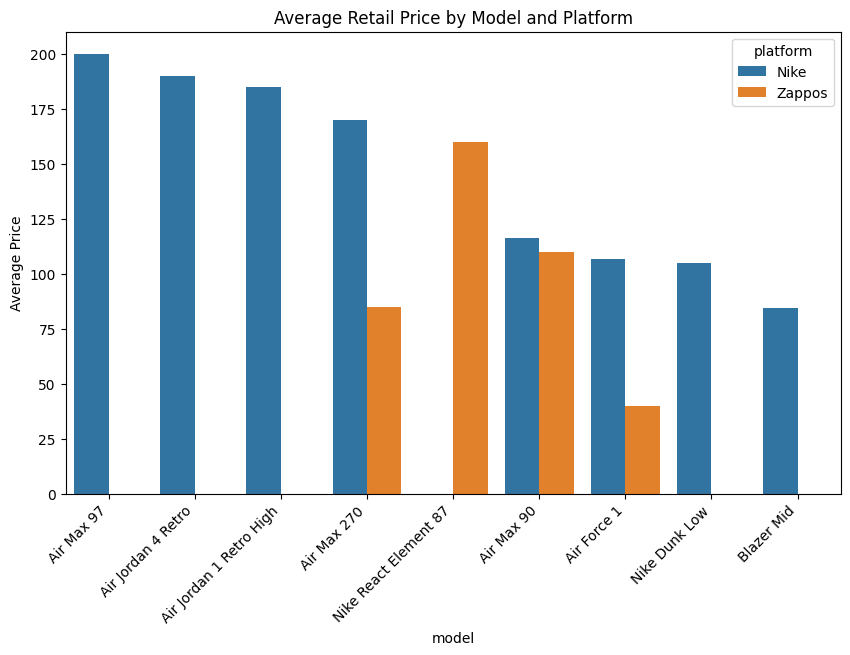

In [42]:
# Plot of Average Retail Price by Model and Platform
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(data=avg_model,
            x="model",
            y="retail_price",
            hue="platform")
plt.xticks(rotation=45, ha="right")
plt.title("Average Retail Price by Model and Platform")
plt.ylabel("Average Price")
plt.show()

In [43]:
# Group average retail price by colorway and platform
avg_colorway = (
    normalized_df.groupby(["platform", "colorway"])["retail_price"]
    .mean()
    .reset_index()
    .sort_values(by="retail_price", ascending=False)
    .reset_index(drop=True)
)
display(avg_colorway)

,platform,colorway,retail_price
0,Nike,Cave Stone and Black,220.000000
1,Nike,Baroque Brown and Sail,185.000000
2,Nike,Shattered Backboard,185.000000
3,Nike,Unknown,124.810625
4,Zappos,Unknown,102.500000


This table shows the average retail price for sneakers grouped by colorway and platform. Premium colorways like “Cave Stone and Black” and “Baroque Brown and Sail” command higher prices on Nike, while listings with unknown colorways tend to be cheaper. These insights help identify which colorways carry a premium and highlight potential opportunities for targeted resale or collection strategies.

In [44]:
# Average prices by edition type
avg_edition = (
    normalized_df.groupby(["platform", "edition_type"])["retail_price"]
    .mean()
    .reset_index()
    .sort_values(by="retail_price", ascending=False)
    .reset_index(drop=True)
)
display(avg_edition)

,platform,edition_type,retail_price
0,Nike,Custom,200.000000
1,Nike,OG,185.000000
2,Nike,Premium,145.000000
3,Nike,Standard,129.228462
4,Zappos,Standard,102.500000
5,Nike,Special Edition,102.000000
6,Nike,Limited Edition,90.000000


This table shows how retail prices vary by edition type across platforms. Custom and OG editions on Nike command the highest prices, while Standard editions are more affordable, especially on Zappos. Special and Limited Editions show moderate pricing, reflecting their rarity or unique features. These insights help understand which editions carry a premium and can guide resale strategy or market monitoring.

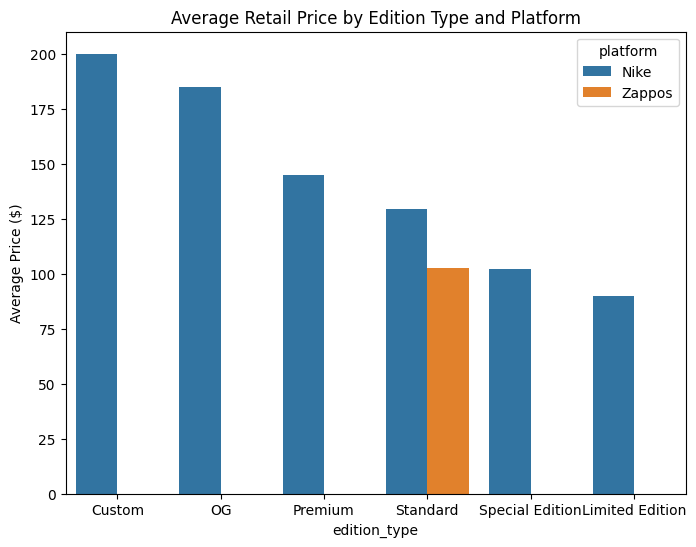

In [45]:
# Plot edition type price comparison
plt.figure(figsize=(8,6))
sns.barplot(data=avg_edition,
            x="edition_type",
            y="retail_price",
            hue="platform")
plt.title("Average Retail Price by Edition Type and Platform")
plt.ylabel("Average Price ($)")
plt.show()

In [46]:
# Top most expensive sneakers
top_expensive = normalized_df.sort_values("retail_price", ascending=False).reset_index().head(10)
display(top_expensive[["brand", "model", "colorway", "platform", "retail_price"]])

,brand,model,colorway,platform,retail_price
0,Nike,Air Jordan 4 Retro,Cave Stone and Black,Nike,220.0
1,Nike,Air Max 97,Unknown,Nike,200.0
2,Nike,Air Max 97,Unknown,Nike,200.0
3,Nike,Air Jordan 1 Retro High,Baroque Brown and Sail,Nike,185.0
4,Nike,Air Jordan 1 Retro High,Shattered Backboard,Nike,185.0
5,Nike,Air Max 270,Unknown,Nike,170.0
6,Nike,Air Jordan 4 Retro,Unknown,Nike,160.0
7,Nike,Nike React Element 87,Unknown,Zappos,160.0
8,Nike,Air Max 90,Unknown,Nike,145.0
9,Nike,Air Max 90,Unknown,Zappos,145.0


Looking at this table, you can see how prices vary depending on the sneaker model, colorway, and where it’s sold. Top-tier colorways like the Air Jordan 4 Retro “Cave Stone and Black” are the most expensive on Nike, while some models with unknown colorways are more affordable, especially on Zappos. This gives a clear picture of which sneakers carry a premium and where price differences across platforms exist, helping guide buying or resale decisions.

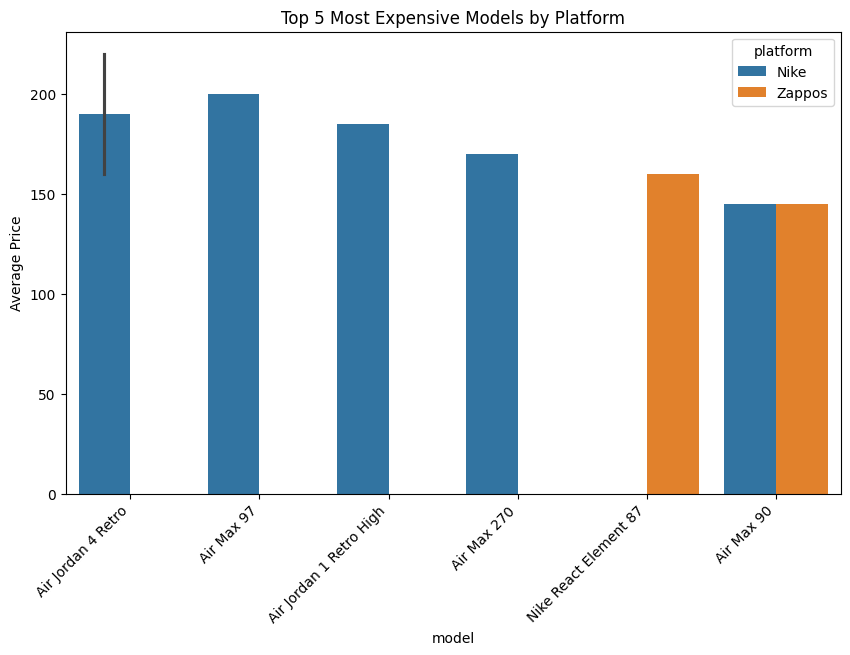

In [47]:
# Plot top expensive sneakers
plt.figure(figsize=(10,6))
sns.barplot(data=top_expensive,
            x="model",
            y ="retail_price",
            hue="platform")
plt.xticks(rotation=45, ha="right")
plt.title("Top 5 Most Expensive Models by Platform")
plt.ylabel("Average Price")
plt.savefig("top_5_most_expensive_models_by_platform.png")
plt.show()

In [48]:
# Price Gap to identify arbitrage opportunities
platform_prices = (
    normalized_df.groupby(["model", "platform"])["retail_price"]
    .mean()
    .unstack()
)
platform_prices

platform,Nike,Zappos
model,,
Air Force 1,106.666667,40.0
Air Jordan 1 Retro High,185.000000,NaN
Air Jordan 4 Retro,190.000000,NaN
Air Max 270,170.000000,85.0
Air Max 90,116.000000,110.0
Air Max 97,200.000000,NaN
Blazer Mid,84.485000,NaN
Nike Dunk Low,104.666667,NaN
Nike React Element 87,NaN,160.0


In [49]:
# Largest gap in platform prices
platform_prices["price_gap"] = (
    platform_prices.max(axis=1) - platform_prices.min(axis=1)
)
largest_gaps = platform_prices.sort_values("price_gap", ascending=False)
display(largest_gaps)

platform,Nike,Zappos,price_gap
model,,,
Air Max 270,170.000000,85.0,85.000000
Air Force 1,106.666667,40.0,66.666667
Air Max 90,116.000000,110.0,6.000000
Air Jordan 4 Retro,190.000000,NaN,0.000000
Air Jordan 1 Retro High,185.000000,NaN,0.000000
Air Max 97,200.000000,NaN,0.000000
Blazer Mid,84.485000,NaN,0.000000
Nike Dunk Low,104.666667,NaN,0.000000
Nike React Element 87,NaN,160.0,0.000000


This table shows how retail prices differ for the same sneaker models across Nike and Zappos. For example, the Air Max 270 and Air Force 1 have significant price gaps, being much cheaper on Zappos. Some models only appear on one platform, which is why their gap is zero. These differences highlight opportunities to spot platform-specific pricing trends and potential resale or buying advantages.

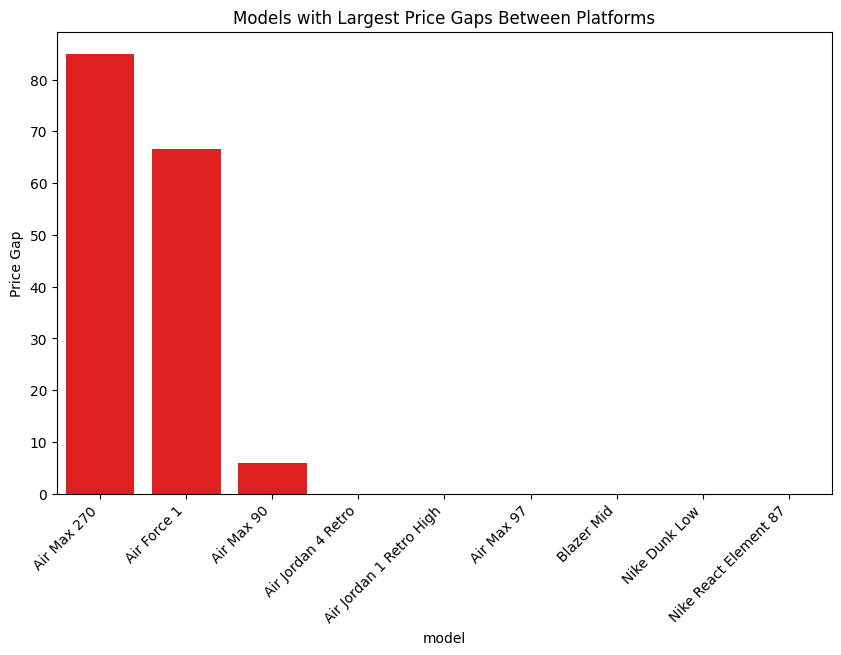

In [50]:
# Plot price gap
largest_gaps_reset = largest_gaps.reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=largest_gaps_reset,
            x="model",
            y="price_gap",
            color="red")
plt.xticks(rotation=45, ha="right")
plt.title("Models with Largest Price Gaps Between Platforms")
plt.ylabel("Price Gap")
plt.savefig("models_with_largest_price_gaps_between_platforms.png")
plt.show()

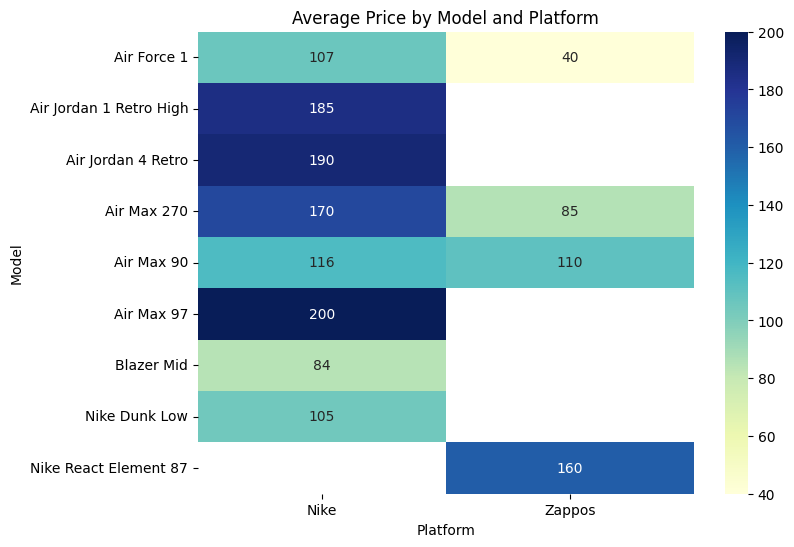

In [51]:
# Plot average retail price heatmap
heatmap_data = (
    normalized_df.groupby(["model", "platform"])["retail_price"]
    .mean()
    .unstack()
)

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data,
            annot=True,
            fmt=".0f",
            cmap="YlGnBu")
plt.title("Average Price by Model and Platform")
plt.ylabel("Model")
plt.xlabel("Platform")
plt.savefig("average_price_by_model_and_platform.png")
plt.show()

This heatmap shows us exactly where we can find the best and worst deals at a glance. For example, the Air Jordan 1 is over $80 cheaper on one platform than the other—that's a huge difference. For our business, this instantly points out which models are being heavily discounted and where, helping us decide where to buy or how to price our own products to stay competitive.

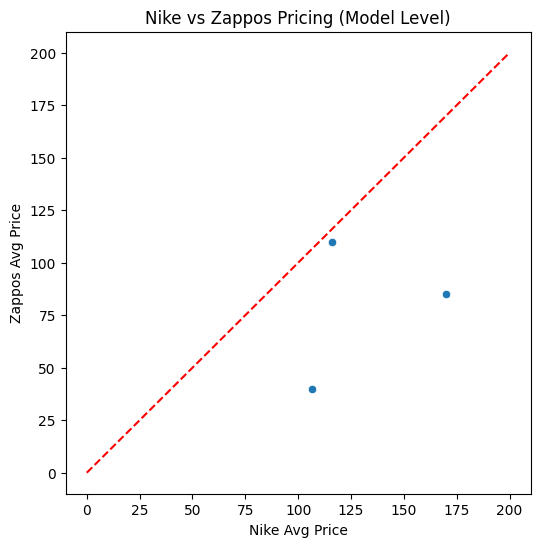

In [52]:
# Correlation between platforms
platform_prices = (
    normalized_df.groupby(["model", "platform"])["retail_price"]
    .mean()
    .unstack()
)

plt.figure(figsize=(6,6))
sns.scatterplot(data=platform_prices, x="Nike", y="Zappos")
plt.title("Nike vs Zappos Pricing (Model Level)")
plt.xlabel("Nike Avg Price")
plt.ylabel("Zappos Avg Price")

max_price = max(platform_prices.max())
plt.plot([0, max_price], [0, max_price], 'r--')
plt.savefig("nike_vs_zappos_pricing.png")
plt.show()

This scatter plot shows the relationship between Nike and Zappos prices for the same sneaker models. Most dots are scattered, which means there's no consistent pricing pattern between the two platforms - the price you get really depends on the specific model. The red dashed line represents perfect price matching; any dot far from this line is a potential deal, making this a quick way to spot pricing anomalies.

**EXPORT CLEANED DATASET FOR POWER BI**

We save the cleaned and normalized sneaker dataset so it can be easily loaded into Power BI. This allows us to create interactive dashboards, visualize trends, and explore insights across platforms, models, and editions without touching the raw data.

In [53]:
# Save normalized data
normalized_df.to_csv("sneaker_prices.csv", index=False)
print("Data exported for Power BI")

Data exported for Power BI


**SAVE TO DATABASE**

Here, we store the structured sneaker data in a database for long-term access and scalability. This ensures that all historical and newly scraped data is centralized, making it easy to query, analyze, and maintain over time.

In [54]:
import sqlite3

# Connect to database
conn = sqlite3.connect("sneaker_prices.db")
normalized_df.to_sql("sneaker_prices", conn, if_exists="append", index=False)
conn.close()
print("Data saved to sneaker_prices.db successfully")

Data saved to sneaker_prices.db successfully


**FULL PIPELINE**

This section ties everything together - scraping, cleaning, normalization, and storage - into a single automated workflow. By running the full pipeline, we can update the dataset continuously, ensuring consistent, accurate, and ready-to-analyze data without manual intervention. It’s the backbone that keeps the project scalable and efficient.

In [55]:
# Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
from datetime import datetime
import time
import random
import re


# Define Configuration
NIKE_TARGET_SNEAKERS = [
    "Air Jordan 1 Retro High",
    "Nike Dunk Low",
    "Air Force 1",
    "Air Max 90",
    "Blazer Mid",
    "Air Max 97",
    "Air Jordan 4 Retro",
    "Nike SB Dunk",
    "Air Max 270",
    "Nike React Element 87"
]

ALLOWED_BRANDS = {"Nike"}

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/120.0.0.0 Safari/537.36"
}

# Column order
STANDARD_COLS = [
    "brand", "model", "title", "colorway", "release_date",
    "retail_price", "resale_price", "product_url",
    "image_url", "platform", "search_query"
]


# Model normalization
def normalize_model(raw_model):
    if not raw_model:
        return None
    model_lower = raw_model.lower()
    if "air jordan 1" in model_lower and "retro" in model_lower:
        return "Air Jordan 1 Retro High"
    elif "dunk low" in model_lower:
        return "Nike Dunk Low"
    elif "air force 1" in model_lower:
        return "Air Force 1"
    elif "air max 90" in model_lower:
        return "Air Max 90"
    elif "blazer mid" in model_lower:
        return "Blazer Mid"
    elif "air max 97" in model_lower:
        return "Air Max 97"
    elif "air jordan 4" in model_lower:
        return "Air Jordan 4 Retro"
    elif "sb dunk" in model_lower:
        return "Nike SB Dunk"
    elif "air max 270" in model_lower:
        return "Air Max 270"
    elif "react element 87" in model_lower:
        return "Nike React Element 87"
    return None

def normalize_model_zappos(raw_model, search_query):
    if not raw_model:
        return None
    raw_lower = raw_model.lower()
    query_lower = search_query.lower()
    target_models = {
        "air jordan 1": "Air Jordan 1 Retro High",
        "dunk low": "Nike Dunk Low",
        "air force 1": "Air Force 1",
        "air max 90": "Air Max 90",
        "blazer mid": "Blazer Mid",
        "air max 97": "Air Max 97",
        "air jordan 4": "Air Jordan 4 Retro",
        "sb dunk": "Nike SB Dunk",
        "air max 270": "Air Max 270",
        "react element 87": "Nike React Element 87"
    }
    for key, model_name in target_models.items():
        if key in raw_lower or key in query_lower:
            return model_name
    return None

def extract_colorway(raw_model, normalized_model):
    if not raw_model or not normalized_model:
        return None

    clean_text = raw_model.replace(normalized_model, '', 1)
    descriptors = [
        r'shoes', r'cleats', r'boots', r'indoor', r'soccer', r'running',
        r'sneakers', r'\(\w+\s*kid[^)]*\)', r'\s+\w+\s*kid'
    ]
    for desc in descriptors:
        clean_text = re.sub(desc, '', clean_text, flags=re.IGNORECASE).strip()

    clean_text = re.sub(r'[\s\W_]+', ' ', clean_text).strip()
    return ' '.join(word.capitalize() for word in clean_text.split()) if clean_text else None


# SCRAPERS

def scrape_nike(query, max_results=5):
    print(f"Searching Nike for: {query}")
    url = f"https://www.nike.com/w?q={query.replace(' ', '%20')}"
    products = []
    try:
        response = requests.get(url, headers=HEADERS, timeout=15)
        response.raise_for_status()
    except Exception as e:
        print(f"Error fetching Nike for {query}: {e}")
        return []

    soup = BeautifulSoup(response.text, "html.parser")
    product_elements = soup.select("figure[data-testid='product-card'], div.product-card")
    if not product_elements:
        print(f"No products found for {query}")
        return []

    for i, item in enumerate(product_elements[:max_results]):
        try:
            model_el = item.select_one("h3.product-card__title, div.product-card__title")
            raw_model = model_el.get_text(strip=True) if model_el else None
            normalized_model = normalize_model(raw_model)
            if not normalized_model:
                continue

            price_el = item.select_one("div.product-price")
            price = price_el.get_text(strip=True) if price_el else None
            if price:
                price = re.sub(r"[^\d.$]", "", price)

            link_el = item.select_one("a")
            product_url = link_el.get("href") if link_el else None
            if product_url and not product_url.startswith("http"):
                product_url = "https://www.nike.com" + product_url

            img_el = item.select_one("img[src]")
            img_url = img_el.get("src") if img_el else None
            if img_url and img_url.startswith("//"):
                img_url = "https:" + img_url

            colorway = extract_colorway(raw_model, normalized_model)

            products.append({
                "brand": "Nike",
                "model": normalized_model,
                "title": f"{normalized_model}",
                "colorway": colorway,
                "release_date": None,
                "retail_price": price,
                "resale_price": None,
                "product_url": product_url,
                "image_url": img_url,
                "platform": "Nike",
                "search_query": query
            })
        except Exception as e:
            print(f"Error parsing Nike product {i+1}: {e}")
            continue

    return products

def search_zappos(query, max_results=5):
    print(f"Searching Zappos for: {query}")
    search_url = f"https://www.zappos.com/search?term={query.replace(' ', '%20')}"
    try:
        res = requests.get(search_url, headers=HEADERS, timeout=15)
        res.raise_for_status()
        soup = BeautifulSoup(res.text, "html.parser")
    except Exception as e:
        print(f"Error fetching Zappos for {query}: {e}")
        return []

    product_elements = soup.select("article")
    if not product_elements:
        print(f"No products found for {query}")
        return []

    products = []
    for i, item in enumerate(product_elements[:max_results]):
        try:
            brand_el = item.select_one("dd[class*='lB-z'] span")
            brand = brand_el.get_text(strip=True) if brand_el else None
            if brand not in ALLOWED_BRANDS:
                continue

            price_el = item.select_one("dd span[class*='u1-z']")
            price = price_el.get_text(strip=True) if price_el else None
            if price:
                price = re.sub(r"[^\d.$]", "", price)

            link_el = item.select_one("a[class*='iB-z']")
            product_url = link_el.get("href") if link_el and link_el.has_attr("href") else None
            if product_url and not product_url.startswith("http"):
                product_url = "https://www.zappos.com" + product_url

            img_el = item.select_one("figure img[src]")
            img_url = img_el.get("src") if img_el else None
            if img_url and img_url.startswith("//"):
                img_url = "https:" + img_url

            name_el = item.select_one("dd[class*='mB-z']")
            raw_model = name_el.get_text(strip=True) if name_el else None
            normalized_model = normalize_model_zappos(raw_model, query)
            if not normalized_model:
                continue

            colorway = extract_colorway(raw_model, normalized_model)
            title = f"{brand} - {normalized_model}" if brand else normalized_model

            products.append({
                "brand": brand,
                "model": normalized_model,
                "title": title,
                "colorway": colorway,
                "release_date": None,
                "retail_price": price,
                "resale_price": None,
                "product_url": product_url,
                "image_url": img_url,
                "platform": "Zappos",
                "search_query": query
            })
        except Exception as e:
            print(f"Error parsing Zappos product {i+1}: {e}")
            continue

    return products


# Cleaning functions

def clean_price(price_str):
    if not price_str:
        return None
    price_str = str(price_str).replace("$", "").replace(",", "").strip()
    try:
        return float(price_str)
    except:
        return None


def clean_colorway_and_edition(colorway):
    if pd.isna(colorway) or colorway.strip() == "":
        return "Unknown", "Standard"

    text = str(colorway).strip()

    known_colorways = {
        'OG "Shattered Backboard"': ("Shattered Backboard", "OG"),
        'OG "Baroque Brown and Sail"': ("Baroque Brown and Sail", "OG"),
        '"Cave Stone and Black"': ("Cave Stone and Black", "Standard"),
        'Cave Stone and Black': ("Cave Stone and Black", "Standard")
    }
    if text in known_colorways:
        return known_colorways[text]

    if "SE" in text or "Special Edition" in text:
        return "Unknown", "Special Edition"
    if "LE" in text or "Limited" in text:
        return "Unknown", "Limited Edition"
    if "Premium" in text:
        return "Unknown", "Premium"
    if "By You" in text:
        return "Unknown", "Custom"
    if "OG" in text:
        clean_color = text.replace('OG "', '').replace('"', '').replace("OG ", "")
        return clean_color, "OG"

    color_words = ["black", "white", "blue", "red", "brown", "stone", "sail", "gray", "green"]
    if any(word in text.lower() for word in color_words):
        return text, "Standard"

    return "Unknown", "Standard"


def normalize_combined_data(df):
    df = df.copy()

    for c in STANDARD_COLS:
        if c not in df.columns:
            df[c] = None

    df = df[STANDARD_COLS]

    df["brand"] = df["brand"].fillna("Unknown").astype(str).str.strip().str.title()
    df["brand"] = df["brand"].replace({
        "Nike, Inc.": "Nike",
        "Nike Usa": "Nike",
        "Nike Usa.": "Nike",
        "Nike USA": "Nike"
    })

    model_map = {
        "Air Force One": "Air Force 1",
        "Airforce 1": "Air Force 1",
        "AJ1 Retro High": "Air Jordan 1 Retro High",
        "Jordan 1 Retro High": "Air Jordan 1 Retro High",
        "Airmax 90": "Air Max 90",
        "Airmax 97": "Air Max 97",
        "React Element 87": "Nike React Element 87"
    }
    df["model"] = df["model"].replace(model_map).astype(str).str.strip()

    # Strip unusual spacing / capitalization for model
    df["model"] = df["model"].str.strip()

    # Normalize titles
    df["title"] = df["title"].fillna("Unknown").astype(str)
    df["title"] = df["title"].str.replace("Nike - ", "", regex=False).str.strip()

    # Colorway normalization
    df["colorway"] = df["colorway"].replace({"": "Unknown", None: "Unknown"}).fillna("Unknown")

    # Release date: skip if Unknown
    df["release_date"] = df["release_date"].replace({"": "Unknown", None: "Unknown"})
    df["release_date"] = df["release_date"].apply(lambda x: x if x != "Unknown" else None)

    # Retail price cleanup
    df["retail_price"] = df["retail_price"].apply(clean_price)

    # Resale price cleanup
    df["resale_price"] = df["resale_price"].replace({"": None})

    # Drop duplicates
    df = df.drop_duplicates(subset=["brand", "model", "colorway", "platform"])

    # Apply colorway cleaner
    df[["colorway", "edition_type"]] = df["colorway"].apply(
        lambda x: pd.Series(clean_colorway_and_edition(x))
    )

    return df



# Save data to csv and database

def save_to_csv(df, filename="combined_sneakers.csv"):
    df.to_csv(filename, index=False)
    print(f"Saved {len(df)} rows to {filename}")


def save_to_db(df, db_name="sneakers.db"):
    conn = sqlite3.connect(db_name)
    df.to_sql("sneaker_prices", conn, if_exists="append", index=False)
    conn.close()
    print(f"Appended {len(df)} rows into {db_name}")



# Run pipeline

def run_pipeline():
    print("SNEAKER PRICE PIPELINE STARTED")

    all_results = []

    for query in NIKE_TARGET_SNEAKERS:
        nike_results = scrape_nike(query)
        zappos_results = search_zappos(query)

        all_results.extend(nike_results)
        all_results.extend(zappos_results)

        time.sleep(random.uniform(2, 4))

    if not all_results:
        print("No products scraped.")
        return

    combined_df = pd.DataFrame(all_results).reset_index(drop=True)

    normalized_df = normalize_combined_data(combined_df)

    normalized_df["run_timestamp"] = datetime.now()

    # Save
    save_to_csv(normalized_df)
    save_to_db(normalized_df)

    print("\nPipeline completed successfully!")
    print(f"Total records processed: {len(normalized_df)}")


# Run pipeline
run_pipeline()

SNEAKER PRICE PIPELINE STARTED
Searching Nike for: Air Jordan 1 Retro High
Searching Zappos for: Air Jordan 1 Retro High
Searching Nike for: Nike Dunk Low
Searching Zappos for: Nike Dunk Low
No products found for Nike Dunk Low
Searching Nike for: Air Force 1
Searching Zappos for: Air Force 1
Searching Nike for: Air Max 90
Searching Zappos for: Air Max 90
Searching Nike for: Blazer Mid
Searching Zappos for: Blazer Mid
Searching Nike for: Air Max 97
Searching Zappos for: Air Max 97
No products found for Air Max 97
Searching Nike for: Air Jordan 4 Retro
Searching Zappos for: Air Jordan 4 Retro
Searching Nike for: Nike SB Dunk
Searching Zappos for: Nike SB Dunk
No products found for Nike SB Dunk
Searching Nike for: Air Max 270
Searching Zappos for: Air Max 270
Searching Nike for: Nike React Element 87
Searching Zappos for: Nike React Element 87
Saved 25 rows to combined_sneakers.csv
Appended 25 rows into sneakers.db

Pipeline completed successfully!
Total records processed: 25


**RECOMMENDATIONS**

The analysis suggests that Nike and Zappos cater to different customer segments, with Nike focusing on premium pricing and Zappos covering a wider range from budget to high-end sneakers. Buyers looking for the latest high-end releases are better off checking Nike, while those hunting for deals or more affordable options may find Zappos more suitable. Premium models and colorways, such as the Air Max 97, Air Jordan 4 Retro, and “Cave Stone and Black,” command higher prices and could be prioritized by resellers or collectors. Edition types also matter, with OG and Custom editions fetching top prices, highlighting where strategic purchasing can yield higher returns. Additionally, significant price gaps between platforms for the same models reveal opportunities for buying on one platform and reselling on another, or for informed pricing adjustments.

**CONCLUSION**

The dataset shows that sneaker prices vary considerably by platform, model, colorway, and edition. Nike consistently maintains premium pricing, while Zappos offers more variety at lower prices. This differentiation provides actionable insights for both buyers and resellers, helping them identify high-value models, colorways, or editions. Understanding these patterns makes it easier to make informed purchasing decisions, monitor market trends, or develop resale strategies based on platform-specific pricing behaviors.

**LIMITATIONS**

Despite the insights, there are some limitations to consider. The data only covers Nike and Zappos within the US market, so trends may differ internationally. Prices were captured at a single point in time, and dynamic pricing, promotions, or sales events could influence the current market. Some colorways, editions, or models had missing or inconsistent data, which may slightly skew averages or comparisons. These factors mean that while the analysis is useful, it may not fully capture the complete pricing landscape.

**FINAL NOTE**

This analysis demonstrates how the sneaker price analysis system meets its intended goals. By systematically collecting and normalizing data from Nike and Zappos, we were able to compare prices across platforms, models, colorways, and editions, revealing clear patterns in pricing behavior. The results highlight how platform-specific strategies, premium editions, and high-demand colorways influence retail pricing, providing actionable insights for buyers, resellers, and market analysts. Automating data collection and storage ensures that these insights can be updated over time, scaling far beyond manual checks. Overall, the findings validate the project’s objective of building a reliable, structured, and insightful system for understanding sneaker market trends in the U.S., while identifying opportunities and gaps that can inform purchasing or monitoring decisions.